Lets import useful packages.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from itertools import compress

In [3]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use(style='seaborn-whitegrid')

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [5]:
from scipy.sparse import hstack

In [6]:
import seaborn as sns

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier

In [8]:
from tabulate import tabulate

In [9]:
from tqdm import tqdm

In [10]:
from wordcloud import WordCloud, STOPWORDS

In [11]:
import numpy as np

In [12]:
import pandas as pd

In [13]:
import pickle

In [14]:
import plotly.graph_objects as go

---

Read the data.

In [15]:
nrows = 50000
data = pd.read_csv(filepath_or_buffer='preprocessed_data.csv', nrows=nrows)
print(data.shape)

(50000, 9)


In [16]:
display(list(data.columns))

['school_state',
 'teacher_prefix',
 'project_grade_category',
 'teacher_number_of_previously_posted_projects',
 'project_is_approved',
 'clean_categories',
 'clean_subcategories',
 'essay',
 'price']

---

Task 1

Data preparation for the model.

In [17]:
y = data['project_is_approved'].values
X = data.drop(labels=['project_is_approved'], axis=1)
print("The shape of X: {}".format(X.shape))
print("The shape of y: {}".format(y.shape))

The shape of X: (50000, 8)
The shape of y: (50000,)


Reference on numerical and categorical columns: https://stackoverflow.com/a/62273776/7579443

In [18]:
numcols = X.select_dtypes('number').columns
catcols = X.select_dtypes('object').columns
numcols= list(set(numcols))
catcols= list(set(catcols))
print(numcols)
print(catcols)

['teacher_number_of_previously_posted_projects', 'price']
['essay', 'project_grade_category', 'teacher_prefix', 'clean_categories', 'clean_subcategories', 'school_state']


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(33500, 8) (33500,)
(16500, 8) (16500,)


---

Glove vectors.

In [20]:
with open(file='glove_vectors', mode='rb') as pkl:
    gmodel = pickle.load(pkl)
    gwords = set(gmodel.keys())

In [21]:
word = list(gwords)[0]
print(word)
dim = len(gmodel[word])
print(dim)

aroostook
300


---

TFIDF W2V representation.

In [22]:
def get_tfidf_w2v(data_col_vals, tfidf_words, dictionary, gmodel=gmodel, gwords=gwords, dim=dim):
    """
    This function gets the categorical column into tfidf_w2v representation.
    """
    tfidf_w2v = list()
    for essay in data_col_vals:
        vect = np.zeros(dim)
        tfidf_weight = 0
        for word in essay.split():
            if (word in gwords) and (word in tfidf_words):
                tfidf_vec = gmodel[word]
                idf = dictionary[word]
                tf = essay.count(word) / len(essay.split())
                vect += (tfidf_vec * tf * idf)
                tfidf_weight += (tf * idf)
        if tfidf_weight > 0:
            vect /= tfidf_weight
        tfidf_w2v.append(vect)
    return tfidf_w2v

def transform_tfidf_w2v(train_data, test_data, colname):
    """
    This function transforms the training and testing data
    into tfidf_w2v representation based on the column name.
    """
    train_col_vals = train_data[colname].values
    test_col_vals = test_data[colname].values
    
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(raw_documents=train_col_vals)
    all_words = tfidf_model.get_feature_names_out()
    dictionary = dict(zip(all_words, tfidf_model.idf_))
    tfidf_words = set(all_words)
    
    train_tfidf_w2v = get_tfidf_w2v(data_col_vals=train_col_vals,
                                    tfidf_words=tfidf_words,
                                    dictionary=dictionary)
    test_tfidf_w2v = get_tfidf_w2v(data_col_vals=test_col_vals,
                                   tfidf_words=tfidf_words,
                                   dictionary=dictionary)
    return train_tfidf_w2v, test_tfidf_w2v

---

Computing polarity scores.

In [23]:
def compute_polar_scores(text_arr):
    """
    This function uses `SentimentIntensityAnalyzer()` to compute polarity.
    """
    polar_scores = list()
    sia = SentimentIntensityAnalyzer()
    for text in tqdm(text_arr):
        ss = sia.polarity_scores(text)
        polar_scores.append(list(ss.values()))
    return np.matrix(data=polar_scores)

---

Encode categorical column.

In [24]:
def encode_categorical_column(train_data, test_data, column, tfidf_w2v_flag=False):
    """
    This function encodes the categorical column.
    """
    if column == 'essay':
        if tfidf_w2v_flag:
            train_vect, test_vect = transform_tfidf_w2v(train_data=train_data,
                                                        test_data=test_data,
                                                        colname=column)
            return train_vect, test_vect
        else:
            encoded_vect = TfidfVectorizer(min_df=10, ngram_range=(1, 4), max_features=5000)
    else:
        encoded_vect = TfidfVectorizer()
    encoded_vect.fit(raw_documents=train_data[column].values)
    train_vect = encoded_vect.transform(raw_documents=train_data[column].values)
    test_vect = encoded_vect.transform(raw_documents=test_data[column].values)
    return train_vect, test_vect

---

Get polarity scores.

In [25]:
def get_polarity_scores(train_data, test_data, column='essay'):
    """
    This function gets the polarity scores.
    """
    train_col_vals = train_data[column].values
    test_col_vals = test_data[column].values
    train_scores = compute_polar_scores(text_arr=train_col_vals)
    test_scores = compute_polar_scores(text_arr=test_col_vals)
    return train_scores, test_scores

---

Normalize numerical column.

In [26]:
def normalize_numerical_column(train_data, test_data, column):
    """
    This function normalizes the numerical column.
    """
    norm = Normalizer()
    try:
        norm.fit(X=train_data[column].values.reshape(1, 1))
    except:
        pass
    train_norm = norm.transform(X=train_data[column].values.reshape(1, -1)).reshape(-1, 1)
    test_norm = norm.transform(X=test_data[column].values.reshape(1, -1)).reshape(-1, 1)
    return train_norm, test_norm

---

Combine all columns.

In [27]:
def combine_all_columns(train_data, test_data, catcols, numcols, tfidf_w2v_flag):
    """
    This function combines all categorical and numerical features.
    """
    train_all_columns = list()
    test_all_columns = list()
    print("Combining categorical features.")
    for catcol in tqdm(catcols):
        train_column_cat, test_column_cat = encode_categorical_column(train_data=train_data,
                                                                      test_data=test_data,
                                                                      column=catcol,
                                                                      tfidf_w2v_flag=tfidf_w2v_flag)
        train_all_columns.append(train_column_cat)
        test_all_columns.append(test_column_cat)
    print("Combining numerical features.")
    for numcol in tqdm(numcols):
        train_column_norm, test_column_norm = normalize_numerical_column(train_data=train_data,
                                                                         test_data=test_data,
                                                                         column=numcol)
        train_all_columns.append(train_column_norm)
        test_all_columns.append(test_column_norm)
    print("Combining scores.")
    train_column_score, test_column_score = get_polarity_scores(train_data=train_data,
                                                                test_data=test_data)
    train_all_columns.append(train_column_score)
    test_all_columns.append(test_column_score)
    print("Preparing model-ready data.")
    train_combined_data = hstack(blocks=train_all_columns).tocsr()
    test_combined_data = hstack(blocks=test_all_columns).tocsr()
    print("Done!")
    return train_combined_data, test_combined_data

---

Batch-wise prediction.

In [28]:
def batch_predict_proba(clf, data, batch_size=1000):
    """
    This function takes the input in batches and predicts
    the probability scores for positive class.
    """
    y_pred_proba = list()
    tr_loop = (data.shape[0] - (data.shape[0] % batch_size))
    for i in range(0, tr_loop, batch_size):
        y_pred_proba.extend(clf.predict_proba(X=data[i:i+batch_size])[:, 1])
    if data.shape[0] % batch_size != 0:
        y_pred_proba.extend(clf.predict_proba(X=data[tr_loop:])[:, 1])
    return y_pred_proba

---

AUC plot.

In [29]:
def draw_auc(best_max_depth,
             best_min_samples_split,
             X_train_data,
             X_test_data,
             y_train,
             y_test,
             plot_it=True):
    """
    Draws AUC plot.
    """
    clf = DecisionTreeClassifier(max_depth=best_max_depth,
                                 min_samples_split=best_min_samples_split,
                                 class_weight='balanced')
    clf.fit(X=X_train_data, y=y_train)
    
    y_train_pred_proba = batch_predict_proba(clf=clf, data=X_train_data)
    y_test_pred_proba = batch_predict_proba(clf=clf, data=X_test_data)
    
    train_fpr, train_tpr, train_taus = roc_curve(y_true=y_train, y_score=y_train_pred_proba)
    test_fpr, test_tpr, test_taus = roc_curve(y_true=y_test, y_score=y_test_pred_proba)
    
    tr_auc = round(auc(x=train_fpr, y=train_tpr), 3)
    te_auc = round(auc(x=test_fpr, y=test_tpr), 3)
    
    if plot_it:
        plt.figure(figsize=(12, 6))
        plt.plot(train_fpr, train_tpr, label='Train AUC = {}'.format(tr_auc))
        plt.plot(test_fpr, test_tpr, label='Test AUC = {}'.format(te_auc))
        plt.title(label='AUC')
        plt.xlabel(xlabel='FPR')
        plt.ylabel(ylabel='TPR')
        plt.legend()
        plt.show()
    else:
        return (y_train_pred_proba,
                y_test_pred_proba,
                train_taus,
                train_fpr,
                train_tpr,
                tr_auc,
                te_auc,
                clf)

---

Best tau and prediction using best tau.

In [30]:
def find_best_tau(taus, fpr, tpr):
    """
    The (tpr*(1-fpr)) will be maximum if fpr is very low and tpr is very high.
    """
    tau = round(taus[np.argmax(a=tpr*(1-fpr))], 3)
    tpr_1_fpr = round(max(tpr*(1-fpr)), 3)
    print("The maximum value of tpr*(1-fpr) is {} for tau {}.".format(tpr_1_fpr, tau))
    return tau

def predict_using_best_tau(proba, best_tau):
    """
    This function predicts using best tau.
    """
    predictions = list()
    for i in proba:
        if i >= best_tau:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

---

In [31]:
def draw_word_count(text_arr):
    """
    This function plots the word cloud.
    """
    feedback_words = str()
    for text in text_arr:
        text = str(text).lower()
        tokens = text.split()
        feedback_words = " ".join(tokens) + " "
    
    word_cloud = WordCloud(width=900,
                           height=900,
                           background_color='white',
                           stopwords=STOPWORDS,
                           min_font_size=10).generate(feedback_words)
    plt.figure(figsize=(9, 9), facecolor=None)
    plt.imshow(X=word_cloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    return None

---

TFIDF - Set 1

Data of Set 1.

In [32]:
X_train_data_tfidf, X_test_data_tfidf = combine_all_columns(train_data=X_train,
                                                            test_data=X_test,
                                                            catcols=catcols,
                                                            numcols=numcols,
                                                            tfidf_w2v_flag=False)

Combining categorical features.


100%|█████████████████████████████████████████████████████████████████████| 6/6 [00:58<00:00,  9.76s/it]


Combining numerical features.


100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1651.95it/s]


Combining scores.


100%|████████████████████████████████████████████████████████████| 16500/16500 [00:19<00:00, 838.34it/s]


Preparing model-ready data.
Done!


`DecisionTreeClassifier`, `GridSearchCV` and 3D scatter plot on Set 1.

In [33]:
params = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}

In [34]:
model1 = DecisionTreeClassifier(class_weight='balanced')
clf1 = GridSearchCV(estimator=model1,
                    param_grid=params,
                    cv=3,
                    scoring='roc_auc',
                    return_train_score=True)
clf1.fit(X=X_train_data_tfidf, y=y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [35]:
results1 = pd.DataFrame.from_dict(clf1.cv_results_).sort_values(['param_min_samples_split'])
display(results1)

train_auc1 = results1['mean_train_score'].values
train_auc_std1 = results1['std_train_score'].values

cv_auc1 = results1['mean_test_score'].values
cv_auc_std1 = results1['std_test_score'].values

x = results1['param_min_samples_split'].values
y = results1['param_max_depth'].values

t1_1 = go.Scatter3d(x=x, y=y, z=train_auc1, name='Train')
t2_1 = go.Scatter3d(x=x, y=y, z=cv_auc1, name='Cross Validation')
traces = [t1_1, t2_1]

layout = go.Layout(
    height=500,
    width=700,
    scene=dict(
        xaxis=dict(title='min_samples_split'),
        yaxis=dict(title='max_depth'),
        zaxis=dict(title='AUC')
    ),
    margin=dict(l=0, r=0, t=0, b=0)
)

fig = go.Figure(data=traces, layout=layout)
fig.show()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.322512      0.014254         0.010961        0.001434   
4        1.545262      0.029116         0.011046        0.000119   
8        3.946553      0.105790         0.011051        0.000045   
12      17.681358      0.312747         0.012638        0.000549   
1        0.331006      0.013228         0.011077        0.000290   
5        1.538013      0.026099         0.011222        0.000474   
9        4.221074      0.119930         0.012135        0.000287   
13      16.407667      0.057481         0.012702        0.000576   
2        0.337246      0.001279         0.011046        0.000041   
6        1.551522      0.058993         0.011181        0.000313   
10       3.763425      0.057369         0.012082        0.000510   
14      11.511937      0.157538         0.012370        0.001332   
3        0.336408      0.000553         0.010962        0.000059   
7        1.503835      0.058193         0.011192        0.000384   
11       3.211160      0.061779         0.012554        0.001025   
15       7.062292      0.296573         0.011018        0.000068   

   param_max_depth param_min_samples_split  \
0                1                       5   
4                5                       5   
8               10                       5   
12              50                       5   
1                1                      10   
5                5                      10   
9               10                      10   
13              50                      10   
2                1                     100   
6                5                     100   
10              10                     100   
14              50                     100   
3                1                     500   
7                5                     500   
11              10                     500   
15              50                     500   

                                         params  split0_test_score  \
0      {'max_depth': 1, 'min_samples_split': 5}           0.543922   
4      {'max_depth': 5, 'min_samples_split': 5}           0.609973   
8     {'max_depth': 10, 'min_samples_split': 5}           0.614302   
12    {'max_depth': 50, 'min_samples_split': 5}           0.549969   
1     {'max_depth': 1, 'min_samples_split': 10}           0.543922   
5     {'max_depth': 5, 'min_samples_split': 10}           0.611756   
9    {'max_depth': 10, 'min_samples_split': 10}           0.615769   
13   {'max_depth': 50, 'min_samples_split': 10}           0.547366   
2    {'max_depth': 1, 'min_samples_split': 100}           0.543922   
6    {'max_depth': 5, 'min_samples_split': 100}           0.611876   
10  {'max_depth': 10, 'min_samples_split': 100}           0.619352   
14  {'max_depth': 50, 'min_samples_split': 100}           0.568832   
3    {'max_depth': 1, 'min_samples_split': 500}           0.543922   
7    {'max_depth': 5, 'min_samples_split': 500}           0.610413   
11  {'max_depth': 10, 'min_samples_split': 500}           0.629519   
15  {'max_depth': 50, 'min_samples_split': 500}           0.594415   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0            0.546690           0.550252         0.546955        0.002591   
4            0.624049           0.623963         0.619329        0.006615   
8            0.630077           0.611416         0.618598        0.008202   
12           0.570624           0.565870         0.562154        0.008832   
1            0.546690           0.550252         0.546955        0.002591   
5            0.624049           0.623963         0.619923        0.005775   
9            0.632485           0.612998         0.620417        0.008608   
13           0.574413           0.572745         0.564841        0.012376   
2            0.546690           0.550252         0.546955        0.002591   
6            0.624767           0.623615         0.620086        0.005824   
10           0.634473     

Best parameters of Set 1.

In [36]:
best_params1 = clf1.best_estimator_.get_params()
best_max_depth1 = best_params1['max_depth']
best_min_samples_split1 = best_params1['min_samples_split']

AUC plot of Set 1.

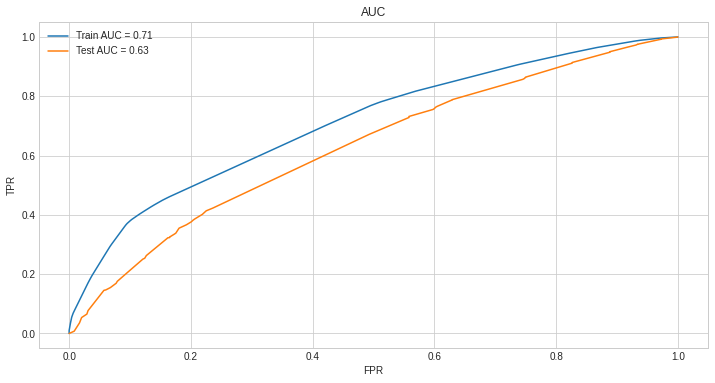

In [37]:
draw_auc(best_max_depth=best_max_depth1,
         best_min_samples_split=best_min_samples_split1,
         X_train_data=X_train_data_tfidf,
         X_test_data=X_test_data_tfidf,
         y_train=y_train,
         y_test=y_test)

Best tau and confusion matrix of Set 1.

In [38]:
(y_train_pred_proba1,
 y_test_pred_proba1,
 train_taus1,
 train_fpr1,
 train_tpr1,
 tr_auc1,
 te_auc1,
 clf1) = draw_auc(best_max_depth=best_max_depth1,
                  best_min_samples_split=best_min_samples_split1,
                  X_train_data=X_train_data_tfidf,
                  X_test_data=X_test_data_tfidf,
                  y_train=y_train,
                  y_test=y_test,
                  plot_it=False)
best_tau1 = find_best_tau(taus=train_taus1, fpr=train_fpr1, tpr=train_tpr1)
print("\nTrain Confusion Matrix")
print(confusion_matrix(y_true=y_train,
                       y_pred=predict_using_best_tau(proba=y_train_pred_proba1,
                                                     best_tau=best_tau1)))
print("\nTest Confusion Matrix")
print(confusion_matrix(y_true=y_test,
                       y_pred=predict_using_best_tau(proba=y_test_pred_proba1,
                                                     best_tau=best_tau1)))

The maximum value of tpr*(1-fpr) is 0.406 for tau 0.484.

Train Confusion Matrix
[[ 4479   886]
 [15146 12989]]

Test Confusion Matrix
[[2017  625]
 [7987 5871]]


Compress iterator: https://www.geeksforgeeks.org/python-itertools-compress/

In [39]:
predictions1 = np.where((np.array(y_test_pred_proba1) > 0.5), 1, 0)
fps1 = (y_test == 0) & (predictions1 == 1)
fp_indicies1 = list(compress(range(len(fps1)), fps1))

Word cloud on `essay` of Set 1.

In [40]:
fp_essay1 = data['essay'][fp_indicies1].values

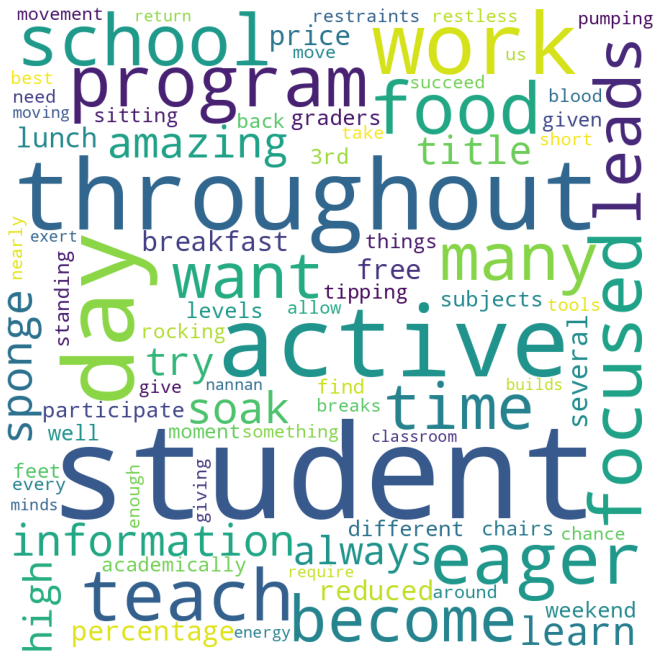

In [41]:
draw_word_count(text_arr=fp_essay1)

Box plot on `price` of Set 1.

In [42]:
fp_price1 = data['price'][fp_indicies1].values

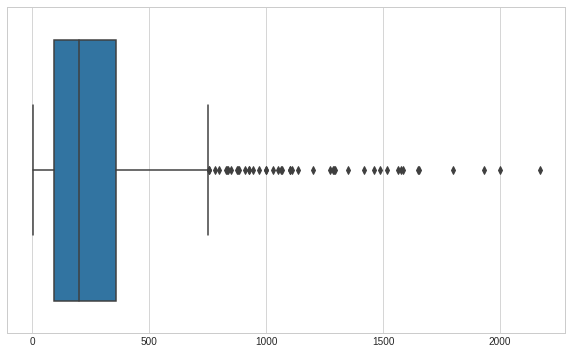

In [43]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=fp_price1)
plt.show()

PDF plot on `teacher_number_of_previously_posted_projects` of Set 1.

In [44]:
fp_tnoppp1 = data['teacher_number_of_previously_posted_projects'][fp_indicies1].values

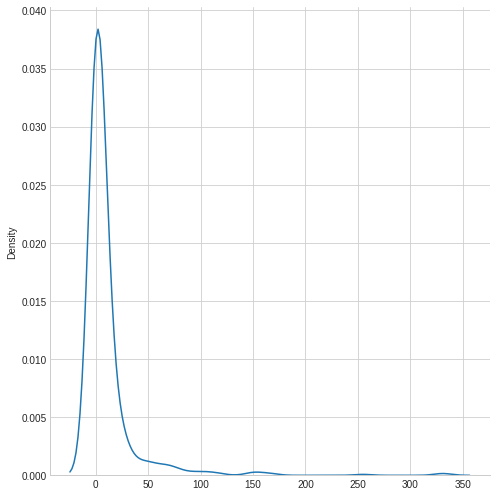

In [45]:
sns.displot(x=fp_tnoppp1, kind='kde', height=7)
plt.show()

---

TFIDF_W2V - Set 2

Data of Set 2.

In [46]:
X_train_data_tfidf_w2v, X_test_data_tfidf_w2v = combine_all_columns(train_data=X_train,
                                                                    test_data=X_test,
                                                                    catcols=catcols,
                                                                    numcols=numcols,
                                                                    tfidf_w2v_flag=True)

Combining categorical features.


100%|█████████████████████████████████████████████████████████████████████| 6/6 [01:10<00:00, 11.76s/it]


Combining numerical features.


100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1433.46it/s]


Combining scores.


100%|████████████████████████████████████████████████████████████| 16500/16500 [00:18<00:00, 900.31it/s]


Preparing model-ready data.
Done!


`DecisionTreeClassifier`, `GridSearchCV` and 3D scatter plot on Set 2.

In [47]:
params = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}

In [48]:
model2 = DecisionTreeClassifier(class_weight='balanced')
clf2 = GridSearchCV(estimator=model2,
                    param_grid=params,
                    cv=3,
                    scoring='roc_auc',
                    return_train_score=True)
clf2.fit(X=X_train_data_tfidf_w2v, y=y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [49]:
results2 = pd.DataFrame.from_dict(clf2.cv_results_).sort_values(['param_min_samples_split'])
display(results2)

train_auc2 = results2['mean_train_score'].values
train_auc_std2 = results2['std_train_score'].values

cv_auc2 = results2['mean_test_score'].values
cv_auc_std2 = results2['std_test_score'].values

x = results2['param_min_samples_split'].values
y = results2['param_max_depth'].values

t1_2 = go.Scatter3d(x=x, y=y, z=train_auc2, name='Train')
t2_2 = go.Scatter3d(x=x, y=y, z=cv_auc2, name='Cross Validation')
traces = [t1_2, t2_2]

layout = go.Layout(
    height=500,
    width=700,
    scene=dict(
        xaxis=dict(title='min_samples_split'),
        yaxis=dict(title='max_depth'),
        zaxis=dict(title='AUC')
    ),
    margin=dict(l=0, r=0, t=0, b=0)
)

fig = go.Figure(data=traces, layout=layout)
fig.show()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.734009      0.008948         0.013995        0.000115   
4        3.564073      0.038524         0.015458        0.001320   
8        9.564075      0.333925         0.015617        0.001139   
12      22.068293      2.412265         0.015874        0.000826   
1        0.730024      0.004002         0.014223        0.000306   
5        3.533092      0.038502         0.014495        0.000147   
9        9.424343      0.207065         0.014581        0.000160   
13      20.712122      1.375257         0.015263        0.000690   
2        0.739967      0.012814         0.014265        0.000295   
6        3.559015      0.036426         0.014622        0.000015   
10       9.691156      0.549974         0.015757        0.000335   
14      17.164727      1.127831         0.015052        0.000032   
3        0.751147      0.012851         0.014583        0.000519   
7        3.461091      0.068256         0.014405        0.000287   
11       7.153109      0.118513         0.015925        0.000056   
15       7.523620      0.457577         0.015998        0.000785   

   param_max_depth param_min_samples_split  \
0                1                       5   
4                5                       5   
8               10                       5   
12              50                       5   
1                1                      10   
5                5                      10   
9               10                      10   
13              50                      10   
2                1                     100   
6                5                     100   
10              10                     100   
14              50                     100   
3                1                     500   
7                5                     500   
11              10                     500   
15              50                     500   

                                         params  split0_test_score  \
0      {'max_depth': 1, 'min_samples_split': 5}           0.543922   
4      {'max_depth': 5, 'min_samples_split': 5}           0.595818   
8     {'max_depth': 10, 'min_samples_split': 5}           0.563543   
12    {'max_depth': 50, 'min_samples_split': 5}           0.532278   
1     {'max_depth': 1, 'min_samples_split': 10}           0.543922   
5     {'max_depth': 5, 'min_samples_split': 10}           0.596164   
9    {'max_depth': 10, 'min_samples_split': 10}           0.565473   
13   {'max_depth': 50, 'min_samples_split': 10}           0.530688   
2    {'max_depth': 1, 'min_samples_split': 100}           0.543922   
6    {'max_depth': 5, 'min_samples_split': 100}           0.596164   
10  {'max_depth': 10, 'min_samples_split': 100}           0.577163   
14  {'max_depth': 50, 'min_samples_split': 100}           0.555406   
3    {'max_depth': 1, 'min_samples_split': 500}           0.543922   
7    {'max_depth': 5, 'min_samples_split': 500}           0.601036   
11  {'max_depth': 10, 'min_samples_split': 500}           0.592159   
15  {'max_depth': 50, 'min_samples_split': 500}           0.590146   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0            0.546690           0.550252         0.546955        0.002591   
4            0.610081           0.612265         0.606055        0.007293   
8            0.578602           0.596308         0.579484        0.013391   
12           0.535688           0.533487         0.533818        0.001411   
1            0.546690           0.550252         0.546955        0.002591   
5            0.610081           0.612265         0.606170        0.007131   
9            0.579339           0.594894         0.579902        0.012018   
13           0.535279           0.534092         0.533353        0.001946   
2            0.546690           0.550252         0.546955        0.002591   
6            0.610188           0.611842         0.606065        0.007033   
10           0.594402     

Best parameters of Set 2.

In [50]:
best_params2 = clf2.best_estimator_.get_params()
best_max_depth2 = best_params2['max_depth']
best_min_samples_split2 = best_params2['min_samples_split']

AUC plot of Set 2.

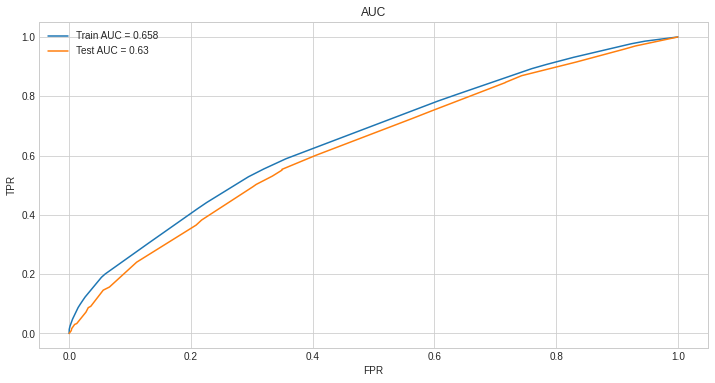

In [51]:
draw_auc(best_max_depth=best_max_depth2,
         best_min_samples_split=best_min_samples_split2,
         X_train_data=X_train_data_tfidf_w2v,
         X_test_data=X_test_data_tfidf_w2v,
         y_train=y_train,
         y_test=y_test)

Best tau and confusion matrix of Set 2.

In [52]:
(y_train_pred_proba2,
 y_test_pred_proba2,
 train_taus2,
 train_fpr2,
 train_tpr2,
 tr_auc2,
 te_auc2,
 clf2) = draw_auc(best_max_depth=best_max_depth2,
                  best_min_samples_split=best_min_samples_split2,
                  X_train_data=X_train_data_tfidf_w2v,
                  X_test_data=X_test_data_tfidf_w2v,
                  y_train=y_train,
                  y_test=y_test,
                  plot_it=False)
best_tau2 = find_best_tau(taus=train_taus2, fpr=train_fpr2, tpr=train_tpr2)
print("\nTrain Confusion Matrix")
print(confusion_matrix(y_true=y_train,
                       y_pred=predict_using_best_tau(proba=y_train_pred_proba2,
                                                     best_tau=best_tau2)))
print("\nTest Confusion Matrix")
print(confusion_matrix(y_true=y_test,
                       y_pred=predict_using_best_tau(proba=y_test_pred_proba2,
                                                     best_tau=best_tau2)))

The maximum value of tpr*(1-fpr) is 0.379 for tau 0.486.

Train Confusion Matrix
[[ 3463  1902]
 [11600 16535]]

Test Confusion Matrix
[[1718  924]
 [6222 7636]]


Compress iterator: https://www.geeksforgeeks.org/python-itertools-compress/

In [53]:
predictions2 = np.where((np.array(y_test_pred_proba2) > 0.5), 1, 0)
fps2 = (y_test == 0) & (predictions2 == 1)
fp_indicies2 = list(compress(range(len(fps2)), fps2))

Word cloud on `essay` of Set 2.

In [54]:
fp_essay2 = data['essay'][fp_indicies2].values

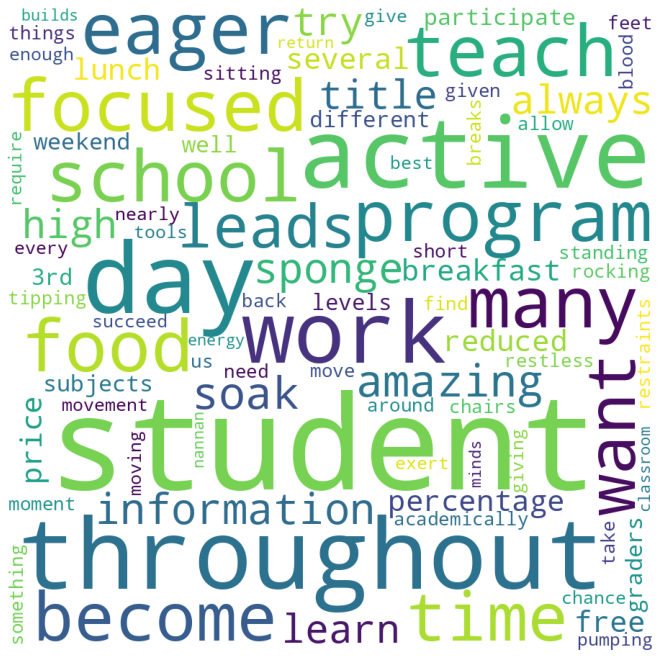

In [55]:
draw_word_count(text_arr=fp_essay2)

Box plot on `price` of Set 2.

In [56]:
fp_price2 = data['price'][fp_indicies2].values

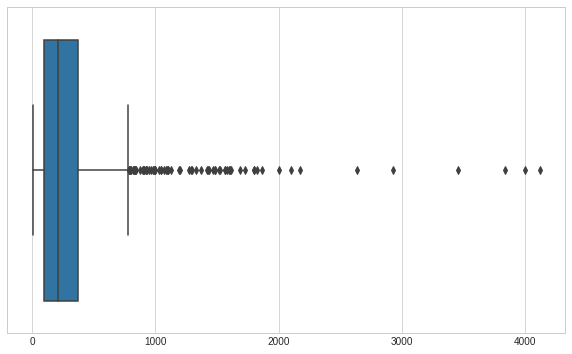

In [57]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=fp_price2)
plt.show()

PDF plot on `teacher_number_of_previously_posted_projects` of Set 2.

In [58]:
fp_tnoppp2 = data['teacher_number_of_previously_posted_projects'][fp_indicies2].values

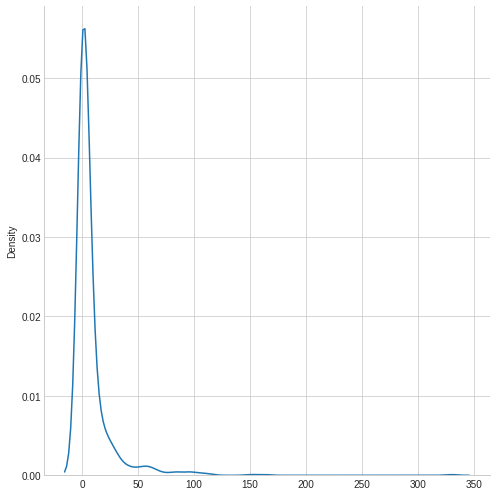

In [59]:
sns.displot(x=fp_tnoppp2, kind='kde', height=7)
plt.show()

---

Task 2

In [60]:
clf = DecisionTreeClassifier()
clf.fit(X=X_train_data_tfidf, y=y_train)

DecisionTreeClassifier()

In [61]:
imp_features = clf.feature_importances_
print(imp_features)
print(len(imp_features))

imp_indicies = np.where(imp_features != 0)[0]
print(imp_indicies)
print(len(imp_indicies))

[0.00021481 0.00076897 0.00078812 ... 0.00590112 0.00397393 0.00140737]
5105
[   0    1    2 ... 5102 5103 5104]
1771


In [62]:
X_train_data_tfidf_imp = np.matrix([row[imp_indicies] for row in X_train_data_tfidf.toarray()])
print(X_train_data_tfidf_imp.shape)

(33500, 1771)


In [63]:
X_test_data_tfidf_imp = np.matrix([row[imp_indicies] for row in X_test_data_tfidf.toarray()])
print(X_test_data_tfidf_imp.shape)

(16500, 1771)


In [64]:
params = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}

In [65]:
max_depth_list = list()
min_samples_split_list = list()
train_score_list = list()
test_score_list = list()

for max_depth in tqdm(params['max_depth']):
    for min_samples_split in params['min_samples_split']:
        estimator = DecisionTreeClassifier(max_depth=max_depth,
                                           min_samples_split=min_samples_split,
                                           class_weight='balanced')
        estimator.fit(X=X_train_data_tfidf_imp, y=y_train)
        train_score = estimator.score(X=X_train_data_tfidf_imp, y=y_train)
        test_score = estimator.score(X=X_test_data_tfidf_imp, y=y_test)
        
        max_depth_list.append(max_depth)
        min_samples_split_list.append(min_samples_split)
        train_score_list.append(train_score)
        test_score_list.append(test_score)

100%|█████████████████████████████████████████████████████████████████████| 4/4 [01:22<00:00, 20.72s/it]


In [66]:
report_df = pd.DataFrame()
report_df['Max Depth'] = max_depth_list
report_df['Minimum Samples Split'] = min_samples_split_list
report_df['Train Score'] = train_score_list
report_df['Test Score'] = test_score_list

In [67]:
report_table = tabulate(tabular_data=report_df, headers='keys', tablefmt='psql')
print(report_table)

+----+-------------+-------------------------+---------------+--------------+
|    |   Max Depth |   Minimum Samples Split |   Train Score |   Test Score |
|----+-------------+-------------------------+---------------+--------------|
|  0 |           1 |                       5 |      0.299672 |     0.258061 |
|  1 |           1 |                      10 |      0.299672 |     0.258061 |
|  2 |           1 |                     100 |      0.299672 |     0.258061 |
|  3 |           1 |                     500 |      0.299672 |     0.258061 |
|  4 |           5 |                       5 |      0.628597 |     0.601697 |
|  5 |           5 |                      10 |      0.628597 |     0.602061 |
|  6 |           5 |                     100 |      0.627373 |     0.600667 |
|  7 |           5 |                     500 |      0.626    |     0.600727 |
|  8 |          10 |                       5 |      0.621433 |     0.549273 |
|  9 |          10 |                      10 |      0.62     |  

---

End of the file.